Routing Phase

In [7]:
!pip install -q pyomo
import numpy as np
import pandas as pd
from pyomo.environ import * 
import pyomo.environ as pyEnv
import math

In [8]:
!apt-get install -y -qq coinor-cbc
opt_cbc = SolverFactory('cbc')

In [9]:
df = pd.read_csv('/content/cVRPsTW250_1.csv')

In [10]:
df.head()

,ORDERID,LON,LAT,START,END,WINDOWTYPE,SERVICETIME,ORDERWEIGHT
0,0,0.0,0.0,0,0,0,0,0
1,1,-2016.0,-7990.0,20334,27534,120,300,5
2,2,-7730.0,7361.0,2134,16534,240,300,5
3,3,613.0,1256.0,4456,5656,20,300,5
4,4,7244.0,-4232.0,32230,35830,60,300,6


In [11]:
dist = []
for ii in range(df.shape[0]):
  temp=[]
  for jj in range(df.shape[0]):
    ab = float(math.dist((df['LAT'][ii],df['LON'][ii]), (df['LAT'][jj],df['LON'][jj])))
    #print(type(ab))
    temp.append(ab/1000)     #km
  dist.append(temp)
print(dist)

[[0.0, 8.24040994125899, 10.674137951141534, 1.3976068832114414, 8.389598321731501, 9.141289460464534, 4.7343972161194925, 9.575229396729878, 10.08301209956628, 5.84627274423628, 6.82108239211344, 1.495535021321801, 6.733959310836381, 10.224384626959218, 8.604883380964555, 10.705399852410933, 5.195238685565852, 4.875955803737355, 8.56128074530908, 2.1879145321515647, 10.951256457594262, 3.633726737111639, 7.280290172788445, 2.229764561562498, 6.17926896970831, 9.911600577101561, 8.47735395037862, 2.868253998515473, 4.367173914558476, 2.052591045483732, 10.026419899445663, 9.119060587582473, 5.595352089011021, 9.921816617938472, 11.050576274565955, 11.200518961191039, 7.573381873377309, 7.460269834262029, 6.778126142231346, 8.714956855888616, 9.522004253307179, 10.296755702647316, 5.49861309786386, 9.531647076974682, 7.6540636265973125, 7.104980225166007, 5.98582208222062, 10.52424980699337, 11.445075141736728, 10.612898991321833, 10.411328685619333, 3.317593880078034, 3.844186976380534

In [12]:
dist_df = pd.DataFrame(dist[0:])

In [13]:
def route(s,dist_df):     # s = cluster set
  n = len(s)
  dist_mh = ConcreteModel()
  row_indices=range(0,n)
  col_indices=range(0,n)
  dist_mh.x = Var(row_indices, col_indices, domain= Binary)
  dist_mh.u=Var(row_indices, domain =NonNegativeIntegers)
  sub_distdf = dist_df.iloc[s,s]
  dist_mh.objective = Objective(expr=sum(sub_distdf.iloc[i,j]*dist_mh.x[i,j] for i in row_indices for j in col_indices if i!=j),sense=minimize)
  dist_mh.constraints = ConstraintList()
  for i in range(n):
    z=0
    for j in range(n):
      if i!=j:
        z+=dist_mh.x[i,j]
    dist_mh.constraints.add(expr=z==1)
  for j in range(n):
    z=0
    for i in range(n):
      if i!=j:  
        z+=dist_mh.x[i,j]  
    dist_mh.constraints.add(expr=z==1)
  for i in range(1,n):
    for j in range(1,n):
      if i!=j:
        dist_mh.constraints.add(expr=dist_mh.u[i]-dist_mh.u[j] + (n-1)*dist_mh.x[i,j]<= (n-2))
  for i in range(1,n):
    dist_mh.constraints.add(expr=dist_mh.u[i]>=0)
    dist_mh.constraints.add(expr=dist_mh.u[i]<=n-2)
  result = opt_cbc.solve(dist_mh)
  aa = []
  for i in range(0,n):
    for j in range(0,n):
      if dist_mh.x[i,j].value==1:
        bb = [i,j]
        aa.append(bb)
  cc=[]
  a = aa[0][0]
  b = aa[0][1]
  cc.append(aa[0])
  #cc.append('-->')
  #print(aa[0])
  for ii in range(1,len(aa)):
    for jj in range(1,len(aa)):
      if aa[jj][0]==b:
        #print(aa[jj])
        cc.append(aa[jj])
        #cc.append('-->')
        a = aa[jj][0]
        b = aa[jj][1]
        break
  a = cc[0][0]
  b = cc[0][1]
  #cc.append(cc[0])
  #cc.append('-->')
  #print(city[a],'--->',city[b])
  ans = [0]
  for ii in range(0,len(cc)):
    for jj in range(0,len(cc)):
      if aa[jj][0]==b:
        ans.append(s[b])
        #print(s[a],'--->',s[b])
        #print(aa[jj])
        #cc.append(aa[jj])
        #cc.append('-->')
        a = aa[jj][0]
        b = aa[jj][1]
        break
  return ans,dist_mh.objective()

# Anticlockwise Direction


In [14]:
cluster = {1: [0, 31, 39, 21, 5, 206, 162, 48, 4, 18],
 2: [0, 175, 50, 134, 247, 45, 115, 164, 192, 204],
 3: [0, 230, 194, 114, 100, 103, 228, 98, 96, 78],
 4: [0, 41, 97, 20, 179, 153, 15, 222, 136, 250, 10],
 5: [0, 231, 133, 25, 119, 219, 215, 130, 212, 28, 225],
 6: [0, 33, 1, 200, 147, 49, 223, 132, 69, 56],
 7: [0, 249, 101, 154, 117, 146, 123, 110, 239, 124],
 8: [0, 14, 211, 37, 245, 72, 203, 243, 191, 184],
 9: [0, 26, 76, 51, 232, 17, 55, 163, 195, 82],
 10: [0, 42, 30, 11, 16, 52, 187, 127, 9, 44],
 11: [0, 173, 85, 95, 180, 155, 248, 8, 113, 19],
 12: [0, 152, 24, 29, 144, 138, 105, 216, 122],
 13: [0, 43, 116, 196, 47, 73, 157, 167],
 14: [0, 34, 87, 150, 12, 2, 160, 58, 198],
 15: [0, 63, 174, 241, 178, 224, 38, 93, 135],
 16: [0, 91, 220, 83, 90, 201, 120, 67, 106],
 17: [0, 139, 108, 92, 125, 208, 137, 190, 129, 62],
 18: [0, 23, 128, 246, 0, 214, 176, 151, 145, 229],
 19: [0, 60, 6, 142, 81, 238, 213, 169, 182, 227, 236, 111, 104, 27],
 20: [0, 185, 183, 171, 177, 32, 46, 168, 172, 165],
 21: [0, 149, 209, 140, 148, 188, 244, 240],
 22: [0, 237, 84, 221, 166, 109, 40, 3, 186, 207],
 23: [0, 233, 126, 242, 86, 70, 193, 13, 199, 65],
 24: [0, 217, 94, 121, 66, 57, 35, 75, 22, 80],
 25: [0, 59, 197, 102, 99, 7, 170, 68, 88, 226, 74],
 26: [0, 118, 158, 181, 36, 71, 112, 218, 141],
 27: [0, 235, 156, 54, 64, 79, 161, 202, 107, 61, 131],
 28: [0, 189, 234, 159, 77, 205, 53, 143, 210, 89]}

In [15]:
from timeit import default_timer as timer

In [16]:
tours = []
anss = 0
start = timer()
for i in range(1,len(cluster)+1):
  print('Optimal route using MTZ formulation for cluster',i)
  hey,bey = route(cluster[i],dist_df)
  print(hey)
  tours.append(hey)
  anss+=bey
  print('_______________________________')
  print('\n')
print(anss)
end = timer()
print('Time taken ',end-start)

Optimal route using MTZ formulation for cluster 1
[0, 21, 31, 39, 5, 48, 18, 4, 162, 206, 0]
_______________________________


Optimal route using MTZ formulation for cluster 2
[0, 192, 115, 164, 204, 50, 175, 134, 45, 247, 0]
_______________________________


Optimal route using MTZ formulation for cluster 3
[0, 100, 194, 114, 230, 103, 96, 228, 98, 78, 0]
_______________________________


Optimal route using MTZ formulation for cluster 4
[0, 136, 222, 179, 97, 153, 41, 20, 15, 10, 250, 0]
_______________________________


Optimal route using MTZ formulation for cluster 5
[0, 231, 133, 25, 28, 219, 119, 215, 225, 212, 130, 0]
_______________________________


Optimal route using MTZ formulation for cluster 6
[0, 200, 1, 33, 147, 49, 56, 223, 132, 69, 0]
_______________________________


Optimal route using MTZ formulation for cluster 7
[0, 249, 154, 101, 117, 146, 123, 124, 110, 239, 0]
_______________________________


Optimal route using MTZ formulation for cluster 8
[0, 37, 14, 211

In [17]:
import matplotlib.pyplot as plt

In [18]:
colors = [np.random.rand(3) for i in range(len(df['ORDERID']))]

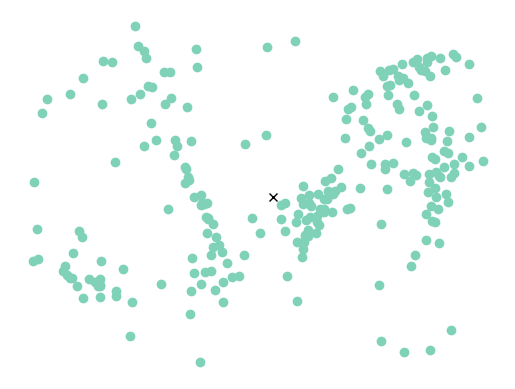

In [19]:
for i in df['ORDERID']:
  if i==0:
    plt.plot(df['LAT'][0],df['LON'][0],'x',color='black')
  else:
    plt.plot(df['LAT'][i],df['LON'][i],'o',color=colors[1])
plt.gca().axis('off');

In [20]:
len(cluster)

28

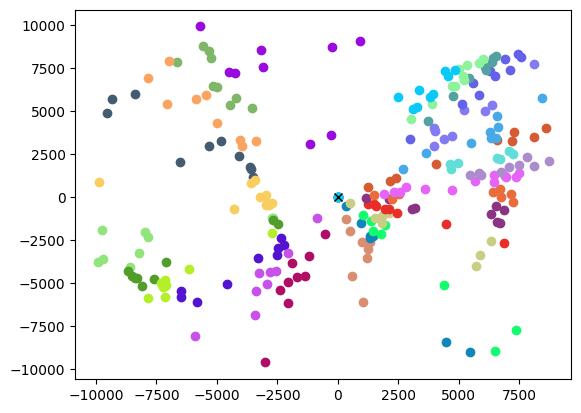

In [21]:
colors = [np.random.rand(3) for i in range(len(df))]
for ii in cluster.keys():
  
  for jj in cluster[ii]:
    #print(jj)
    plt.plot(df['LAT'][jj],df['LON'][jj],'o',color=colors[ii])
plt.plot(df['LAT'][0],df['LON'][0],'x',color='black')
plt.show()

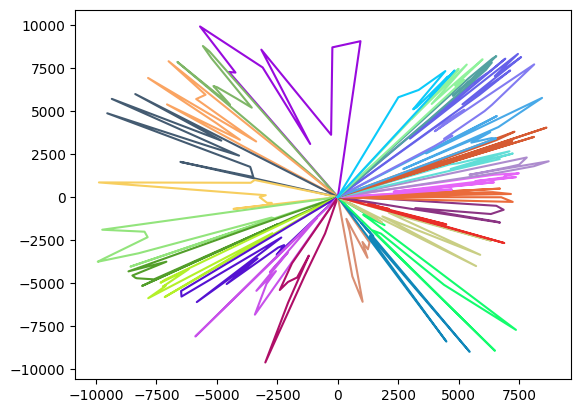

In [22]:
for jj in cluster.keys():
  x= [df['LAT'][ii] for ii in cluster[jj]]
  x.append(0)
  y= [df['LON'][ii] for ii in cluster[jj]]
  y.append(0)
  plt.plot(x,y,color=colors[jj])

# Clockwise Direction

In [23]:
cluster2 = {1: [0, 89, 210, 143, 53, 205, 77, 159, 234, 189],
 2: [0, 131, 61, 107, 202, 161, 79, 64, 54, 156, 235],
 3: [0, 141, 218, 112, 71, 36, 181, 158, 118, 74],
 4: [0, 226, 88, 68, 170, 7, 99, 102, 197, 59, 80],
 5: [0, 22, 75, 35, 57, 66, 121, 94, 217],
 6: [0, 65, 199, 13, 193, 70, 86, 242, 126, 233],
 7: [0, 207, 186, 3, 40, 109, 166, 221, 84, 237],
 8: [0, 240, 244, 188, 148, 140, 209, 149, 165],
 9: [0, 172, 168, 46, 32, 177, 171, 183, 185, 27, 104, 111],
 10: [0, 236, 227, 182, 169, 213, 238, 81, 142, 6, 60, 229],
 11: [0, 145, 151, 176, 214, 0, 246, 128, 23, 62, 129],
 12: [0, 190, 137, 208, 125, 92, 108, 139, 106, 67],
 13: [0, 120, 201, 90, 83, 220, 91, 135],
 14: [0, 93, 38, 224, 178, 241, 174, 63, 198, 58, 160],
 15: [0, 2, 12, 150, 87, 34, 167, 157],
 16: [0, 73, 47, 196, 116, 43, 122, 216],
 17: [0, 105, 138, 144, 29, 24, 152, 19, 113],
 18: [0, 8, 248, 155, 180, 95, 85, 173, 44, 9, 127, 187, 52],
 19: [0, 16, 11, 30, 42, 82, 195, 163, 55, 17],
 20: [0, 232, 51, 76, 26, 184, 191, 243, 203],
 21: [0, 72, 245, 37, 211, 14, 124, 239, 110, 123, 146, 117],
 22: [0, 154, 101, 249, 56, 69, 132, 223, 49, 147],
 23: [0, 200, 1, 33, 225, 28, 212, 130, 215],
 24: [0, 219, 119, 25, 133, 231, 10, 250, 136, 222, 15, 153],
 25: [0, 179, 20, 97, 41, 78, 96, 98, 228, 103],
 26: [0, 100, 114, 194, 230, 204, 192, 164, 115, 45],
 27: [0, 247, 134, 50, 175, 18, 4, 48, 162, 206],
 28: [0, 5, 21, 39, 31]}

In [24]:
tours = []
anss = 0
start = timer()
for i in range(1,len(cluster)+1):
  print('Optimal route using MTZ formulation for cluster',i)
  hey,bey = route(cluster2[i],dist_df)
  print(hey)
  tours.append(hey)
  anss+=bey
  print('_______________________________')
  print('\n')
print(anss)
end = timer()
print('Time taken ',end-start)

Optimal route using MTZ formulation for cluster 1
[0, 89, 210, 143, 234, 77, 189, 159, 205, 53, 0]
_______________________________


Optimal route using MTZ formulation for cluster 2
[0, 61, 131, 107, 54, 64, 79, 235, 156, 161, 202, 0]
_______________________________


Optimal route using MTZ formulation for cluster 3
[0, 36, 141, 71, 218, 112, 181, 158, 74, 118, 0]
_______________________________


Optimal route using MTZ formulation for cluster 4
[0, 68, 226, 88, 170, 99, 197, 7, 59, 102, 80, 0]
_______________________________


Optimal route using MTZ formulation for cluster 5
[0, 217, 121, 94, 66, 57, 35, 22, 75, 0]
_______________________________


Optimal route using MTZ formulation for cluster 6
[0, 199, 65, 13, 193, 86, 233, 126, 242, 70, 0]
_______________________________


Optimal route using MTZ formulation for cluster 7
[0, 84, 166, 109, 221, 237, 40, 207, 186, 3, 0]
_______________________________


Optimal route using MTZ formulation for cluster 8
[0, 240, 244, 209, 188, 

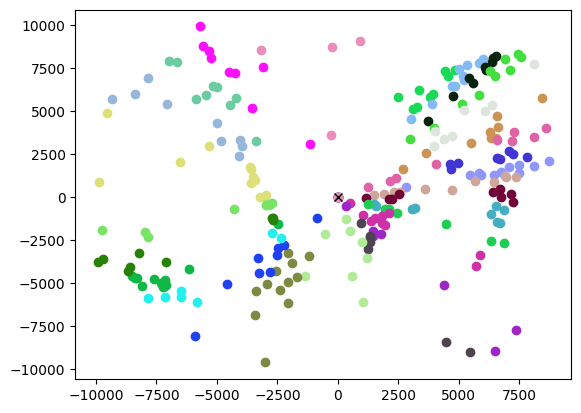

In [25]:
colors = [np.random.rand(3) for i in range(len(df))]
for ii in cluster2.keys():
  
  for jj in cluster2[ii]:
    #print(jj)
    plt.plot(df['LAT'][jj],df['LON'][jj],'o',color=colors[ii])
plt.plot(df['LAT'][0],df['LON'][0],'x',color='black')
plt.show()

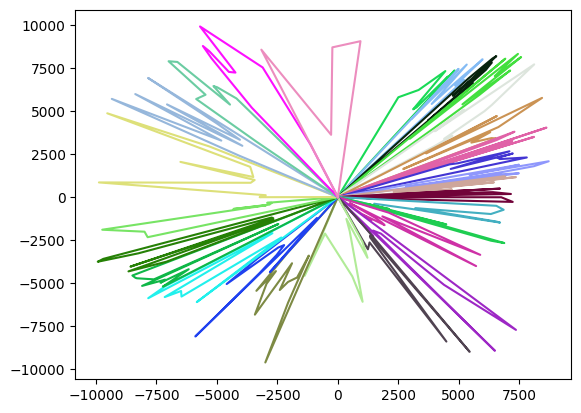

In [26]:
for jj in cluster2.keys():
  x= [df['LAT'][ii] for ii in cluster2[jj]]
  x.append(0)
  y= [df['LON'][ii] for ii in cluster2[jj]]
  y.append(0)
  plt.plot(x,y,color=colors[jj])

# FFNC Algorithm

In [27]:
cluster3 = {1: [0, 48, 50, 175, 134, 18, 4, 115, 164, 194],
 2: [0, 35, 99, 170, 88, 112, 218, 181, 71, 158],
 3: [0, 34, 47, 43, 2, 12, 178, 38],
 4: [0, 20, 15, 41, 103, 230, 204, 114, 96, 228, 97],
 5: [0, 49, 147, 56, 101, 117, 146, 123, 124, 110, 211],
 6: [0, 197, 7, 226, 64, 54, 107, 131, 234, 143, 77],
 7: [0, 13, 40, 237, 207, 221, 188, 140, 165],
 8: [0, 8, 44, 187, 9, 85, 95, 180, 113, 173, 52, 195],
 9: [0, 30, 232, 76, 26, 203, 72, 245, 14],
 10: [0, 33, 1, 200, 223, 154, 37, 55, 42],
 11: [0, 25, 10, 153, 98, 78, 179, 222, 136, 250],
 12: [0, 243, 184, 17, 82, 163, 51, 191, 239],
 13: [0, 5, 162, 45, 192, 247, 100, 206, 21, 68],
 14: [0, 31, 39, 89, 53, 205, 202, 159, 189, 210, 161, 156],
 15: [0, 177, 171, 172, 168, 183, 236, 227, 169, 111, 104, 81, 145],
 16: [0, 141, 235, 79, 74, 59, 57, 66, 65],
 17: [0, 193, 86, 126, 233, 186, 209, 149, 46, 185, 182],
 18: [0, 36, 102, 22, 94, 121, 75, 80, 118, 61],
 19: [0, 91, 135, 108, 92, 208, 190, 137],
 20: [0, 128, 214, 246, 176, 32, 244, 240, 148],
 21: [0, 248, 127, 16, 155, 19, 11, 144, 73],
 22: [0, 242, 217, 199, 109, 70, 166, 84, 213, 151],
 23: [0, 24, 152, 138, 216, 122, 116, 196],
 24: [0, 90, 125, 139, 220, 93, 120, 83, 224, 174],
 25: [0, 6, 238, 27, 142, 23, 129, 60, 229, 62, 201, 106],
 26: [0, 28, 219, 119, 215, 212, 130, 225, 132, 69],
 27: [0, 133, 231, 249, 167, 241, 58, 160, 63, 198],
 28: [0, 105, 157, 87, 150, 29, 67, 3]}

In [28]:
tours = []
anss = 0
start = timer()
for i in range(1,len(cluster3)+1):
  print('Optimal route using MTZ formulation for cluster',i)
  hey,bey = route(cluster3[i],dist_df)
  print(hey)
  tours.append(hey)
  anss+=bey
  print('_______________________________')
  print('\n')
print(anss)
end = timer()
print('Time taken ',end-start)

Optimal route using MTZ formulation for cluster 1
[0, 194, 115, 164, 134, 175, 50, 48, 18, 4, 0]
_______________________________


Optimal route using MTZ formulation for cluster 2
[0, 35, 99, 170, 88, 112, 218, 181, 71, 158, 0]
_______________________________


Optimal route using MTZ formulation for cluster 3
[0, 38, 178, 2, 34, 47, 43, 12, 0]
_______________________________


Optimal route using MTZ formulation for cluster 4
[0, 228, 114, 204, 230, 103, 41, 20, 15, 96, 97, 0]
_______________________________


Optimal route using MTZ formulation for cluster 5
[0, 147, 49, 56, 101, 117, 146, 123, 124, 110, 211, 0]
_______________________________


Optimal route using MTZ formulation for cluster 6
[0, 77, 143, 234, 131, 107, 64, 54, 226, 197, 7, 0]
_______________________________


Optimal route using MTZ formulation for cluster 7
[0, 188, 140, 165, 237, 40, 13, 207, 221, 0]
_______________________________


Optimal route using MTZ formulation for cluster 8
[0, 195, 52, 173, 9, 187, 44

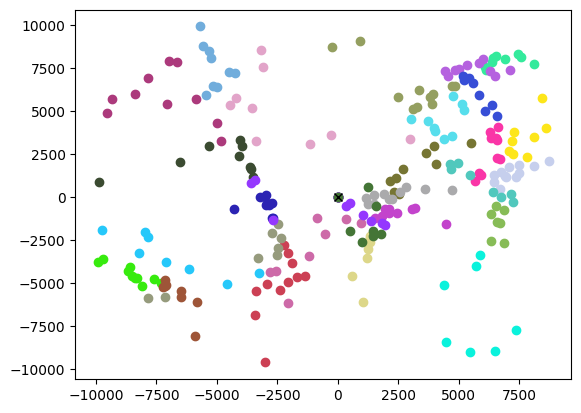

In [29]:
colors = [np.random.rand(3) for i in range(len(df))]
for ii in cluster3.keys():
  
  for jj in cluster3[ii]:
    #print(jj)
    plt.plot(df['LAT'][jj],df['LON'][jj],'o',color=colors[ii])
plt.plot(df['LAT'][0],df['LON'][0],'x',color='black')
plt.show()

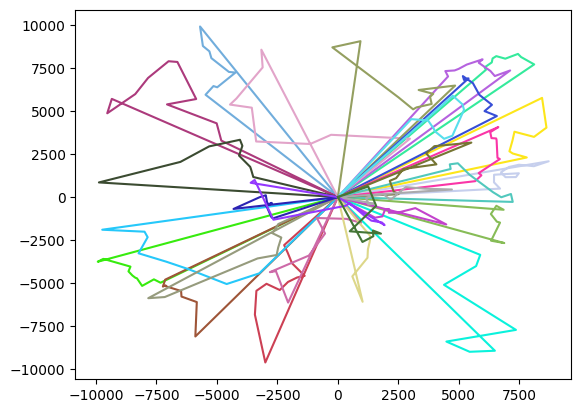

In [30]:
for jj in cluster3.keys():
  x= [df['LAT'][ii] for ii in cluster3[jj]]
  x.append(0)
  y= [df['LON'][ii] for ii in cluster3[jj]]
  y.append(0)
  plt.plot(x,y,color=colors[jj])

In [31]:
cluster3.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [42]:
# colors = [np.random.rand(3) for i in range(len(df))]
  
# for jj in cluster3[28]:
#   #print(jj)
#   plt.plot(df['LAT'][jj],df['LON'][jj],'o',label = jj)
# plt.plot(df['LAT'][0],df['LON'][0],'x',color='black')
# plt.legend
# plt.show()

In [43]:
# x= [df['LAT'][ii] for ii in cluster3[28]]
# x.append(0)
# y= [df['LON'][ii] for ii in cluster3[28]]
# y.append(0)
# plt.plot(x,y,color=colors[28])

# NFNC Algorithm

In [35]:
cluster4 = {1 : [0, 167, 241, 62, 229, 60, 129, 23, 151, 142],
2 : [0, 144, 73, 160, 174, 224, 93, 120, 83, 67],
3 : [0, 201, 106, 58, 63, 198, 150, 157, 196],
4 : [0, 3, 84, 166, 70, 27, 213, 220, 139, 125, 238, 6, 182],
5 : [0, 11, 19, 29, 105, 122, 116, 87, 216],
6 : [0, 130, 212, 215, 225, 219, 119, 133, 231, 250, 136, 222],
7 : [0, 239, 249, 69, 132, 191, 51, 195, 163, 82, 52],
8 : [0, 206, 21, 100, 78, 98, 97, 153, 179],
9 : [0, 155, 173, 127, 16, 42, 9, 187, 85, 95],
10 : [0, 138, 152, 24, 113, 180, 248, 44, 55, 232],
11 : [0, 28, 17, 37, 154, 14, 211, 245, 203, 72, 110],
12 : [0, 199, 217, 121, 94, 75, 80, 118, 61, 53],
13 : [0, 109, 240, 148, 244, 32, 46, 185, 104, 183],
14 : [0, 68, 205, 202, 159, 189, 210, 89, 36, 161, 156],
15 : [0, 90, 208, 92, 108, 137, 190, 246],
16 : [0, 247, 45, 192, 115, 164, 194, 114, 96, 41],
17 : [0, 242, 126, 233, 186, 86, 193, 65, 66, 57],
18 : [0, 176, 145, 81, 236, 227, 169, 111, 172, 168, 149, 209],
19 : [0, 228, 10, 25, 33, 147, 49, 56, 101, 117, 146],
20 : [0, 12, 178, 38, 135, 91, 128, 214],
21 : [0, 22, 102, 59, 74, 141, 235, 79, 131, 234],
22 : [0, 188, 140, 165, 171, 177, 237, 40, 207],
23 : [0, 221, 13, 35, 99, 170, 88, 112, 218, 181, 71],
24 : [0, 162, 5, 4, 18, 134, 175, 50, 48],
25 : [0, 200, 1, 223, 123, 124, 243, 184, 76],
26 : [0, 77, 143, 107, 64, 54, 158, 226, 7, 197],
27 : [0, 26, 30, 8, 43, 47, 34, 2, 31, 39],
28 : [0, 204, 230, 103, 20, 15]}

In [36]:
tours = []
anss = 0
start = timer()
for i in range(1,len(cluster4)+1):
  print('Optimal route using MTZ formulation for cluster',i)
  hey,bey = route(cluster4[i],dist_df)
  print(hey)
  tours.append(hey)
  anss+=bey
  print('_______________________________')
  print('\n')
print(anss)
end = timer()
print('Time taken ',end-start)

Optimal route using MTZ formulation for cluster 1
[0, 167, 241, 129, 23, 151, 142, 60, 229, 62, 0]
_______________________________


Optimal route using MTZ formulation for cluster 2
[0, 144, 73, 160, 174, 224, 93, 120, 83, 67, 0]
_______________________________


Optimal route using MTZ formulation for cluster 3
[0, 58, 196, 157, 150, 198, 63, 106, 201, 0]
_______________________________


Optimal route using MTZ formulation for cluster 4
[0, 220, 139, 125, 6, 182, 238, 27, 70, 166, 84, 213, 3, 0]
_______________________________


Optimal route using MTZ formulation for cluster 5
[0, 87, 116, 122, 216, 105, 29, 19, 11, 0]
_______________________________


Optimal route using MTZ formulation for cluster 6
[0, 222, 136, 250, 231, 133, 219, 119, 215, 225, 212, 130, 0]
_______________________________


Optimal route using MTZ formulation for cluster 7
[0, 132, 69, 249, 239, 191, 51, 195, 163, 82, 52, 0]
_______________________________


Optimal route using MTZ formulation for cluster 8
[0

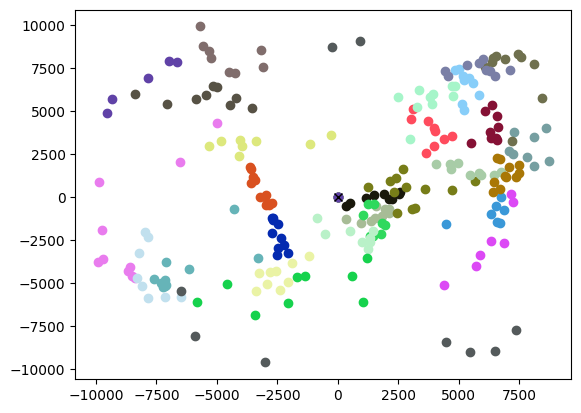

In [38]:
colors = [np.random.rand(3) for i in range(len(df))]
for ii in cluster4.keys():
  
  for jj in cluster4[ii]:
    #print(jj)
    plt.plot(df['LAT'][jj],df['LON'][jj],'o',color=colors[ii])
plt.plot(df['LAT'][0],df['LON'][0],'x',color='black')
plt.show()

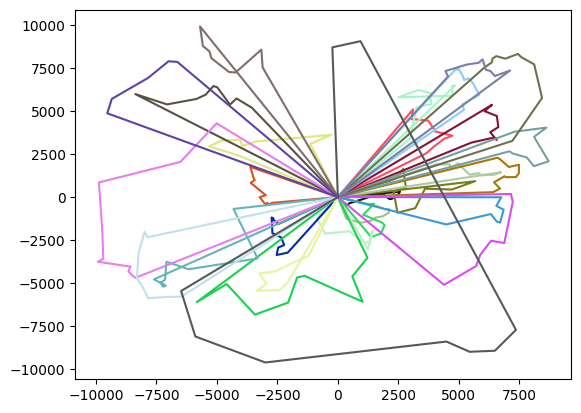

In [39]:
for jj in cluster4.keys():
  x= [df['LAT'][ii] for ii in cluster4[jj]]
  x.append(0)
  y= [df['LON'][ii] for ii in cluster4[jj]]
  y.append(0)
  plt.plot(x,y,color=colors[jj])

In [40]:
cluster4.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])